# DTSA 5510 Final Project

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import permutations

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

from langdetect import detect

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
3178,8088919,2023-08-21,True,5,Great briefcase,I’m a Tumi fan now. This is a high quality and...,United States
9205,8518199,2018-02-05,True,1,Does bot fit costco KP26M9,"If you are wondering don’t waste your time, it...",Australia
7053,780251,2013-06-13,True,5,Couldn't Live Without It,I don't tolerate fat very well when I eat - it...,United States
3823,2213205,2021-10-29,True,2,Not mint,This scent is disappointing. It has a somewhat...,United States
7483,5847458,2017-12-19,True,4,It does what it says and looks great when it's up,It does what it says and looks great when it's...,United States


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   NAME          10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


### Changing NAME field to Country

In [5]:
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

### Dropping the only row with a null value

In [6]:
#
reviews[reviews['REVIEW_TITLE'].isnull()]

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
2517,3566087,2018-08-09,True,5,NaN,Excellent product that is really helping my dog,United States


In [7]:
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [8]:
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            9999 non-null   int64 
 1   REVIEW_DATE   9999 non-null   object
 2   IS_VERIFIED   9999 non-null   bool  
 3   RATING        9999 non-null   int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   9999 non-null   object
 6   COUNTRY       9999 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 556.6+ KB


### Converting REVIEW_DATE field to pandas datetime

In [10]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


In [11]:
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])

### Converting ID field to type object

In [12]:
reviews['ID'] = reviews['ID'].astype(object)

In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            9999 non-null   object        
 1   REVIEW_DATE   9999 non-null   datetime64[ns]
 2   IS_VERIFIED   9999 non-null   bool          
 3   RATING        9999 non-null   int64         
 4   REVIEW_TITLE  9999 non-null   object        
 5   REVIEW_TEXT   9999 non-null   object        
 6   COUNTRY       9999 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 556.6+ KB


In [14]:
reviews.describe()

,REVIEW_DATE,RATING
count,9999,9999.000000
mean,2019-05-12 18:08:27.650765056,3.708071
min,2000-06-17 00:00:00,1.000000
25%,2016-11-07 00:00:00,2.000000
50%,2020-01-06 00:00:00,5.000000
75%,2022-08-11 00:00:00,5.000000
max,2024-06-17 00:00:00,5.000000
std,NaN,1.625120


## Visualizations

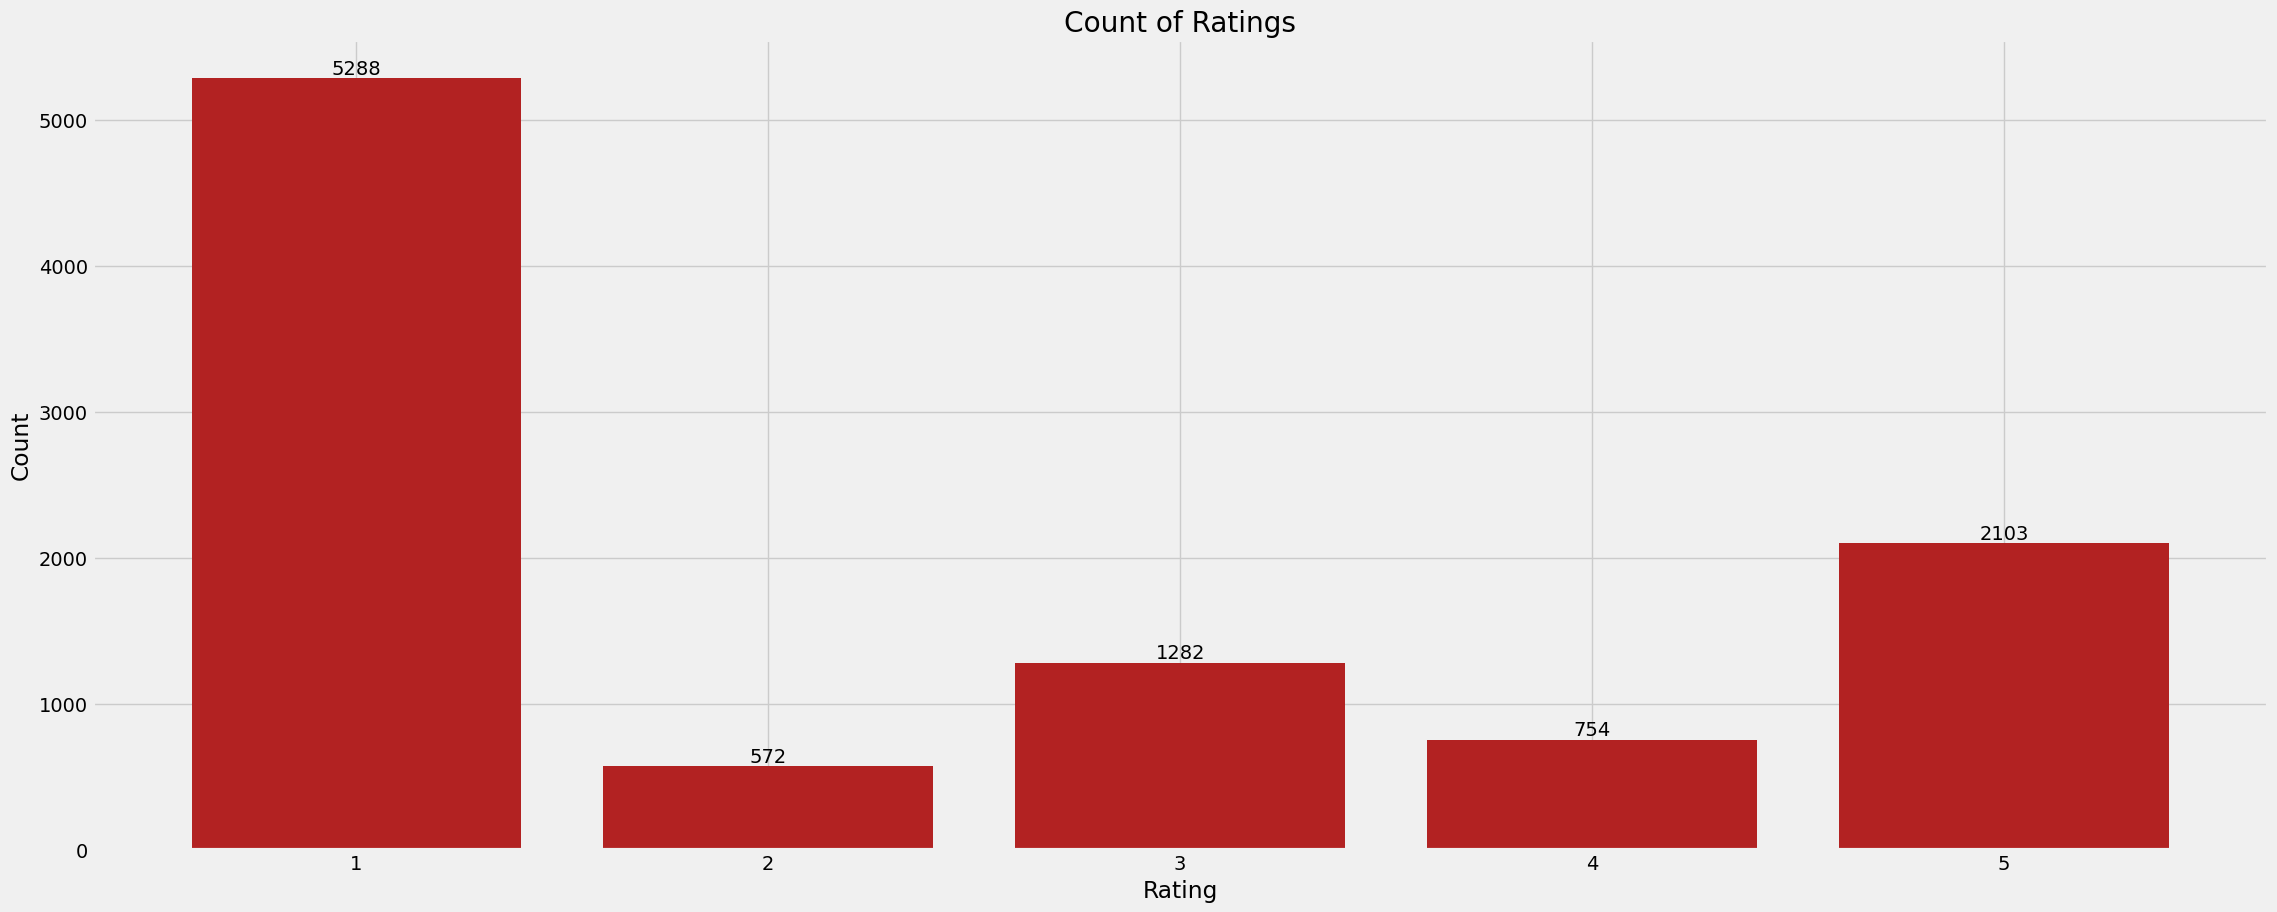

In [15]:
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = reviews['RATING'].value_counts()
ind = reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [16]:
# dataset is unbalanced, but that is ok in our context as we will not be exploring the relationship between variables, just the underlying text

In [17]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


## Removing non-english reviews

In [18]:
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [19]:
reviews['language'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [20]:
reviews['language'].value_counts()

language
en         9603
es          103
de           74
ja           63
fr           57
it           35
pt           12
ca            9
af            8
ro            7
no            6
so            5
da            3
nl            3
id            2
et            2
tl            2
cy            1
tr            1
unknown       1
sl            1
cs            1
Name: count, dtype: int64

In [21]:
english_mask = reviews['language'] == 'en'
english_reviews = reviews[english_mask]

In [22]:
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_50210/1936066079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


Text(0.5, 1.0, 'Number of words by review histogram')

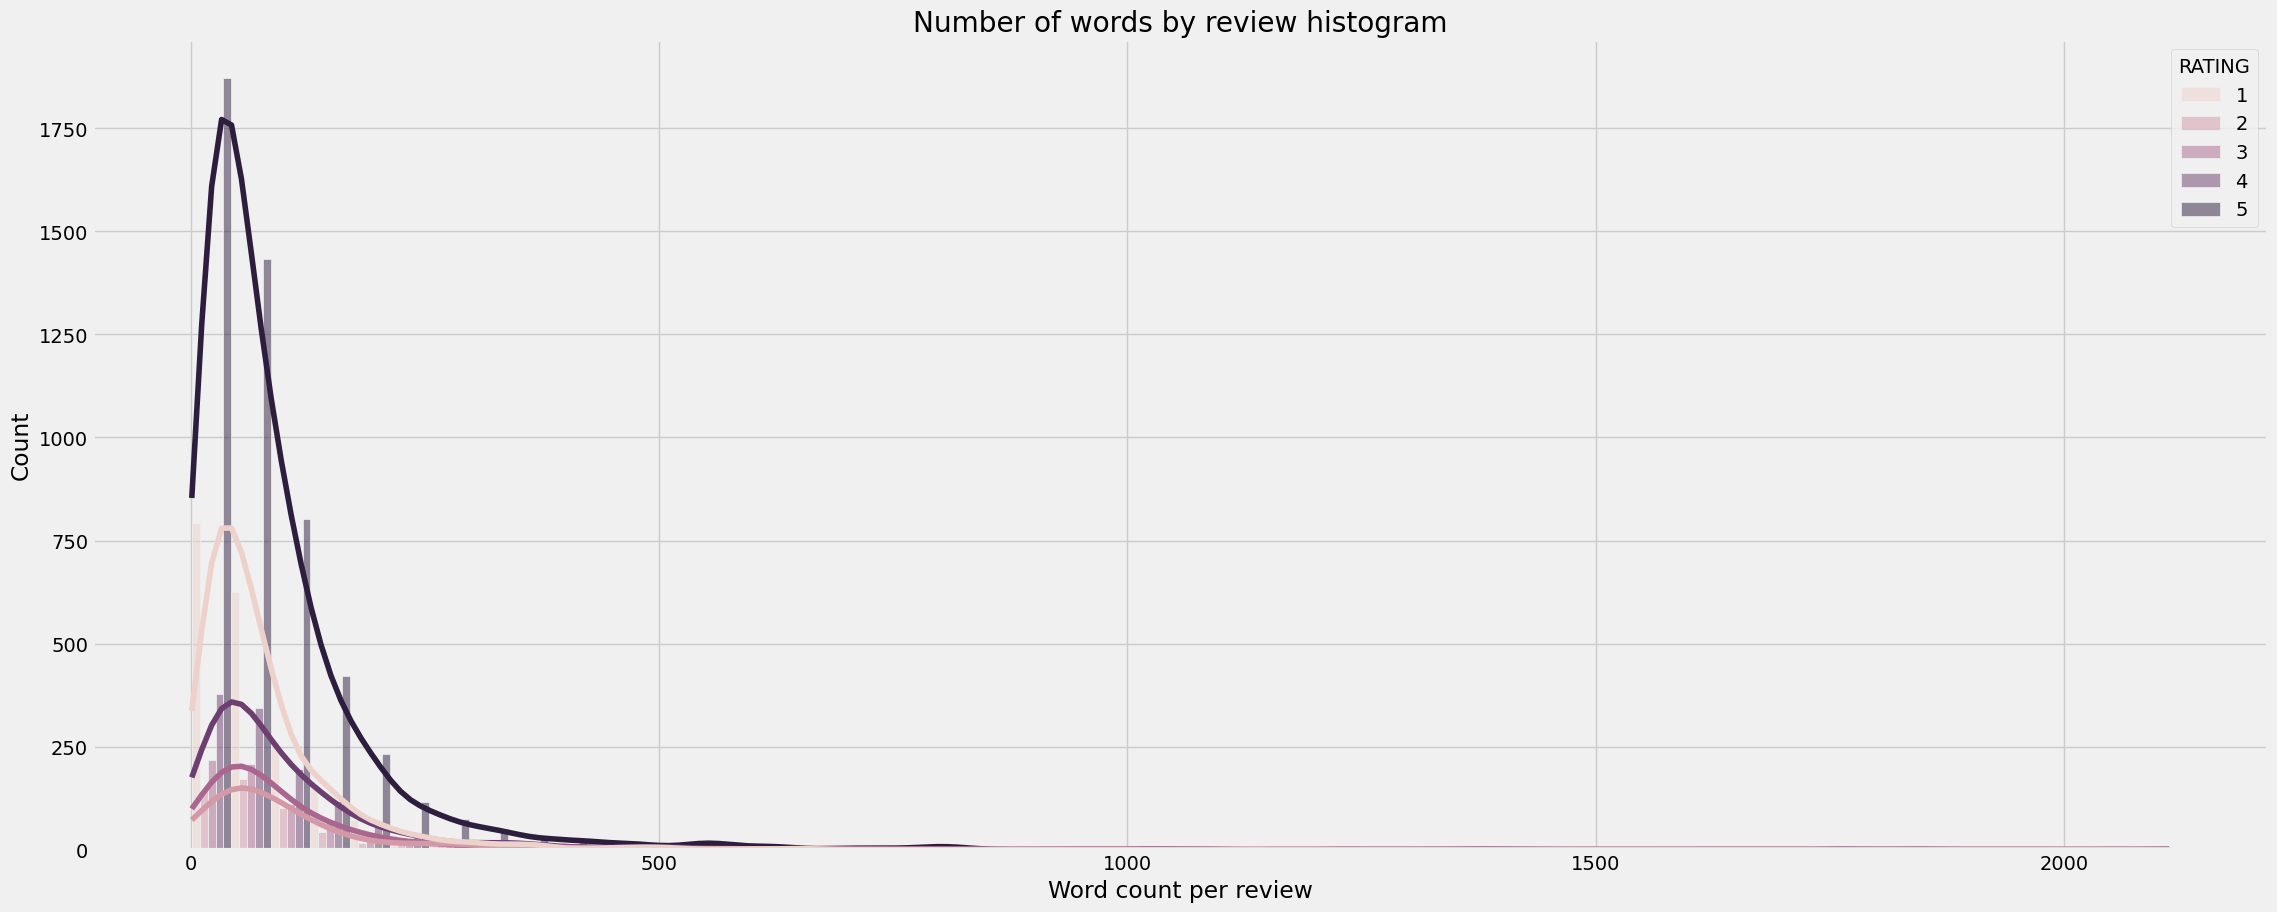

In [23]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 50)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_50210/3030392025.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

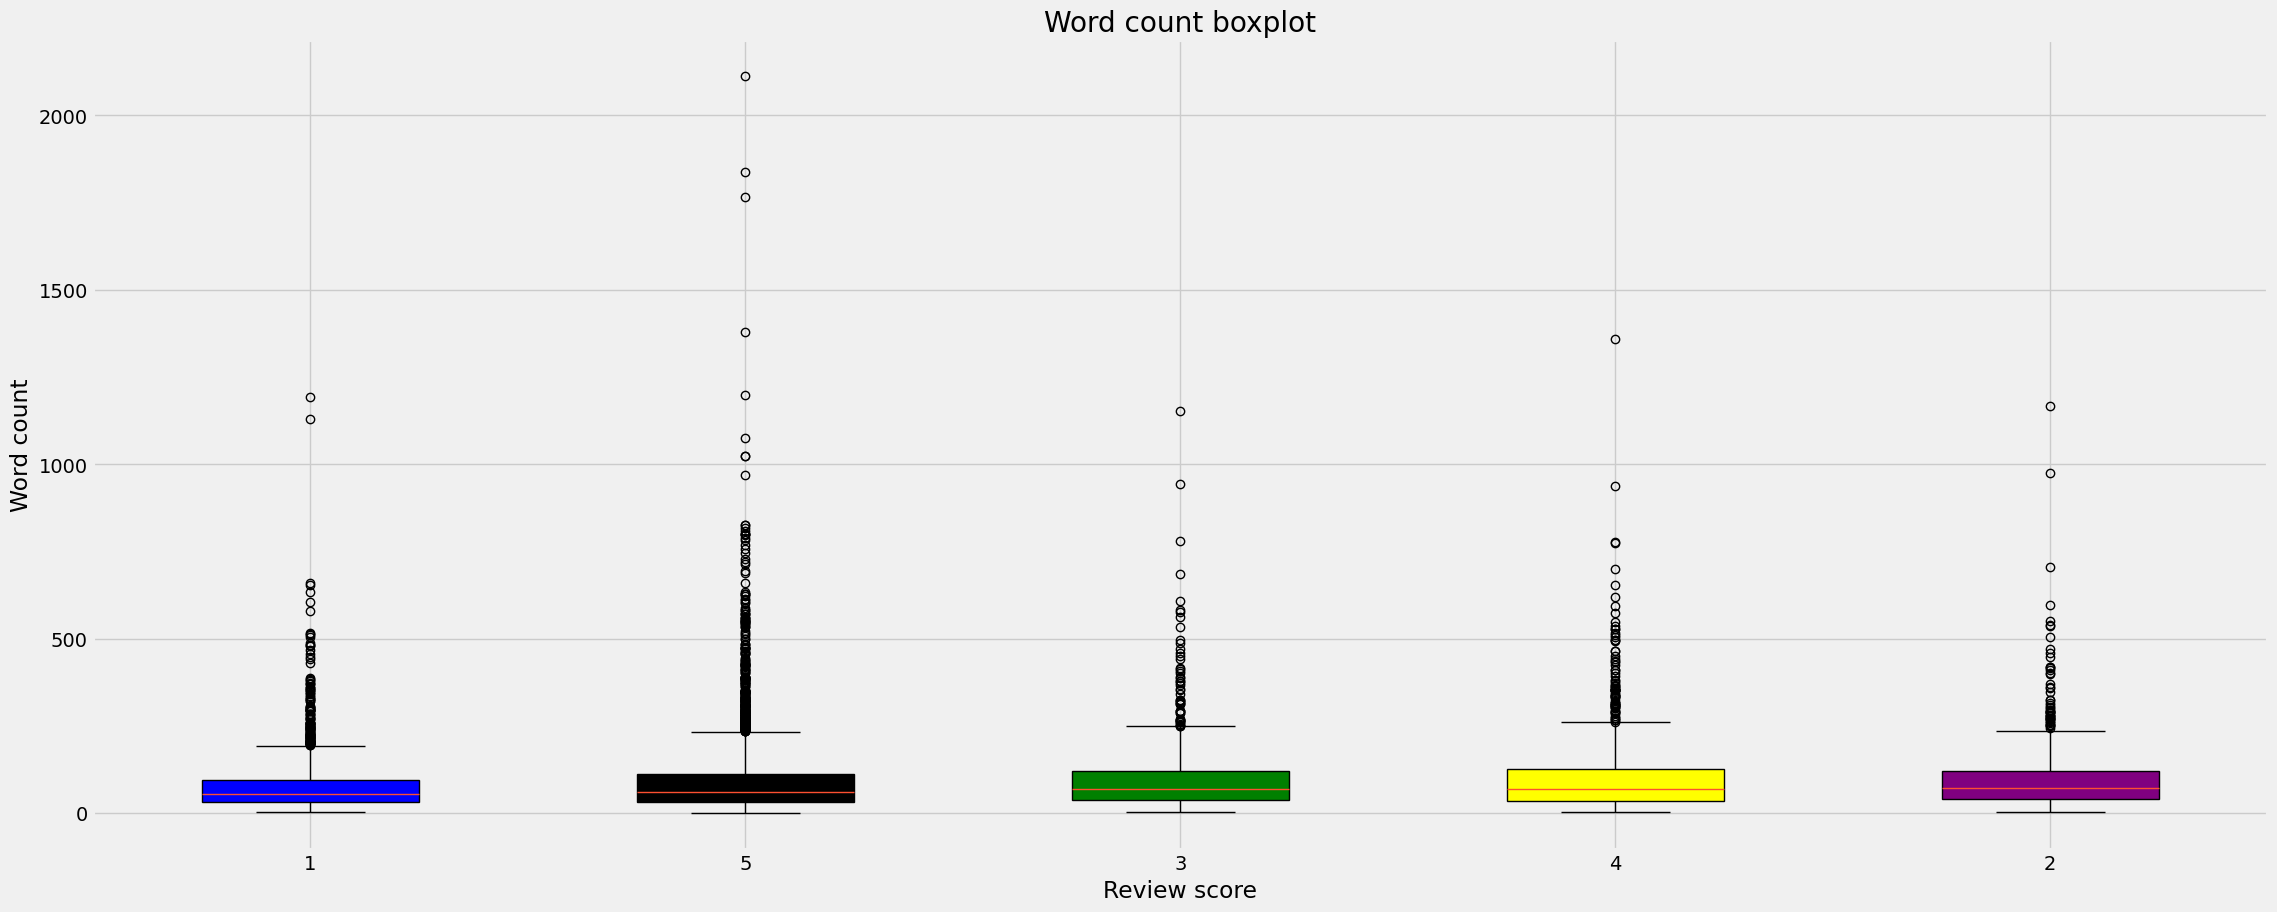

In [24]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

# Train Test Split

In [25]:
# final sample of the english_reviews dataset that will be split into training and testing datasets
english_reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,language,word_count
6062,8517597,2016-12-12,True,2,Not worth the effort,Unfortunately this did not work well for us wi...,Australia,en,24
971,9178829,2023-02-22,True,4,From Black to Ginger using Copper,"I’ve put my hair through a lot of colors, most...",United States,en,106
8836,310495,2017-08-22,True,3,Steep price for 8 oz. My fault for not readin...,A little steep in price for 8 oz. I guess I d...,United States,en,55
2783,5521962,2011-06-17,True,5,Great Mascara,I Have tried many Mascaras and intill this day...,United States,en,21
687,7108598,2014-06-11,False,5,Works for me!,I only use this product once a day as recommen...,United States,en,147


In [26]:
english_reviews_train, english_reviews_test = train_test_split(english_reviews, test_size=0.15, random_state=42)

In [27]:
print(f'The number of rows in the training dataset is: {len(english_reviews_train)}')

The number of rows in the training dataset is: 8162


In [28]:
print(f'The number of rows in the testing dataset is: {len(english_reviews_test)}')

The number of rows in the testing dataset is: 1441


In [29]:
y = english_reviews_train['RATING'].tolist()
english_reviews_train_text = english_reviews_train['REVIEW_TEXT']

# Implementing TF-IDF

In [30]:
tfidf = TfidfVectorizer(ngram_range =(1,2), stop_words = 'english', max_features = 1000)
features = tfidf.fit_transform(english_reviews_train_text)
df_tfidf = pd.DataFrame(features.toarray(), columns = tfidf.get_feature_names_out())

In [31]:
# original review
english_reviews_train.iloc[2]['REVIEW_TEXT']

"Unfortunately after using for about 2 weeks caused my blood presssure to get high. I'm normally 118/70. Got as high as 143/93. I did read that this can be one of the side effects of licorice root. So back to Nexium twice a day. Was really hoping this product would work for me. Been off for a week and blood pressure back to normal."

In [32]:
df_tfidf_three  = df_tfidf.iloc[2]
sorted_doc_three_scores = df_tfidf_three.sort_values(ascending=False)

In [33]:
sorted_doc_three_scores[:20]

blood             0.433366
high              0.352847
blood pressure    0.271028
caused            0.237698
hoping            0.235770
normally          0.231297
pressure          0.226104
twice             0.216986
effects           0.216083
unfortunately     0.212103
normal            0.205569
read              0.180772
week              0.174347
weeks             0.174011
got               0.146397
did               0.140691
work              0.136766
day               0.135656
using             0.133867
really            0.127148
Name: 2, dtype: float64

Text(0.5, 0, 'Terms')

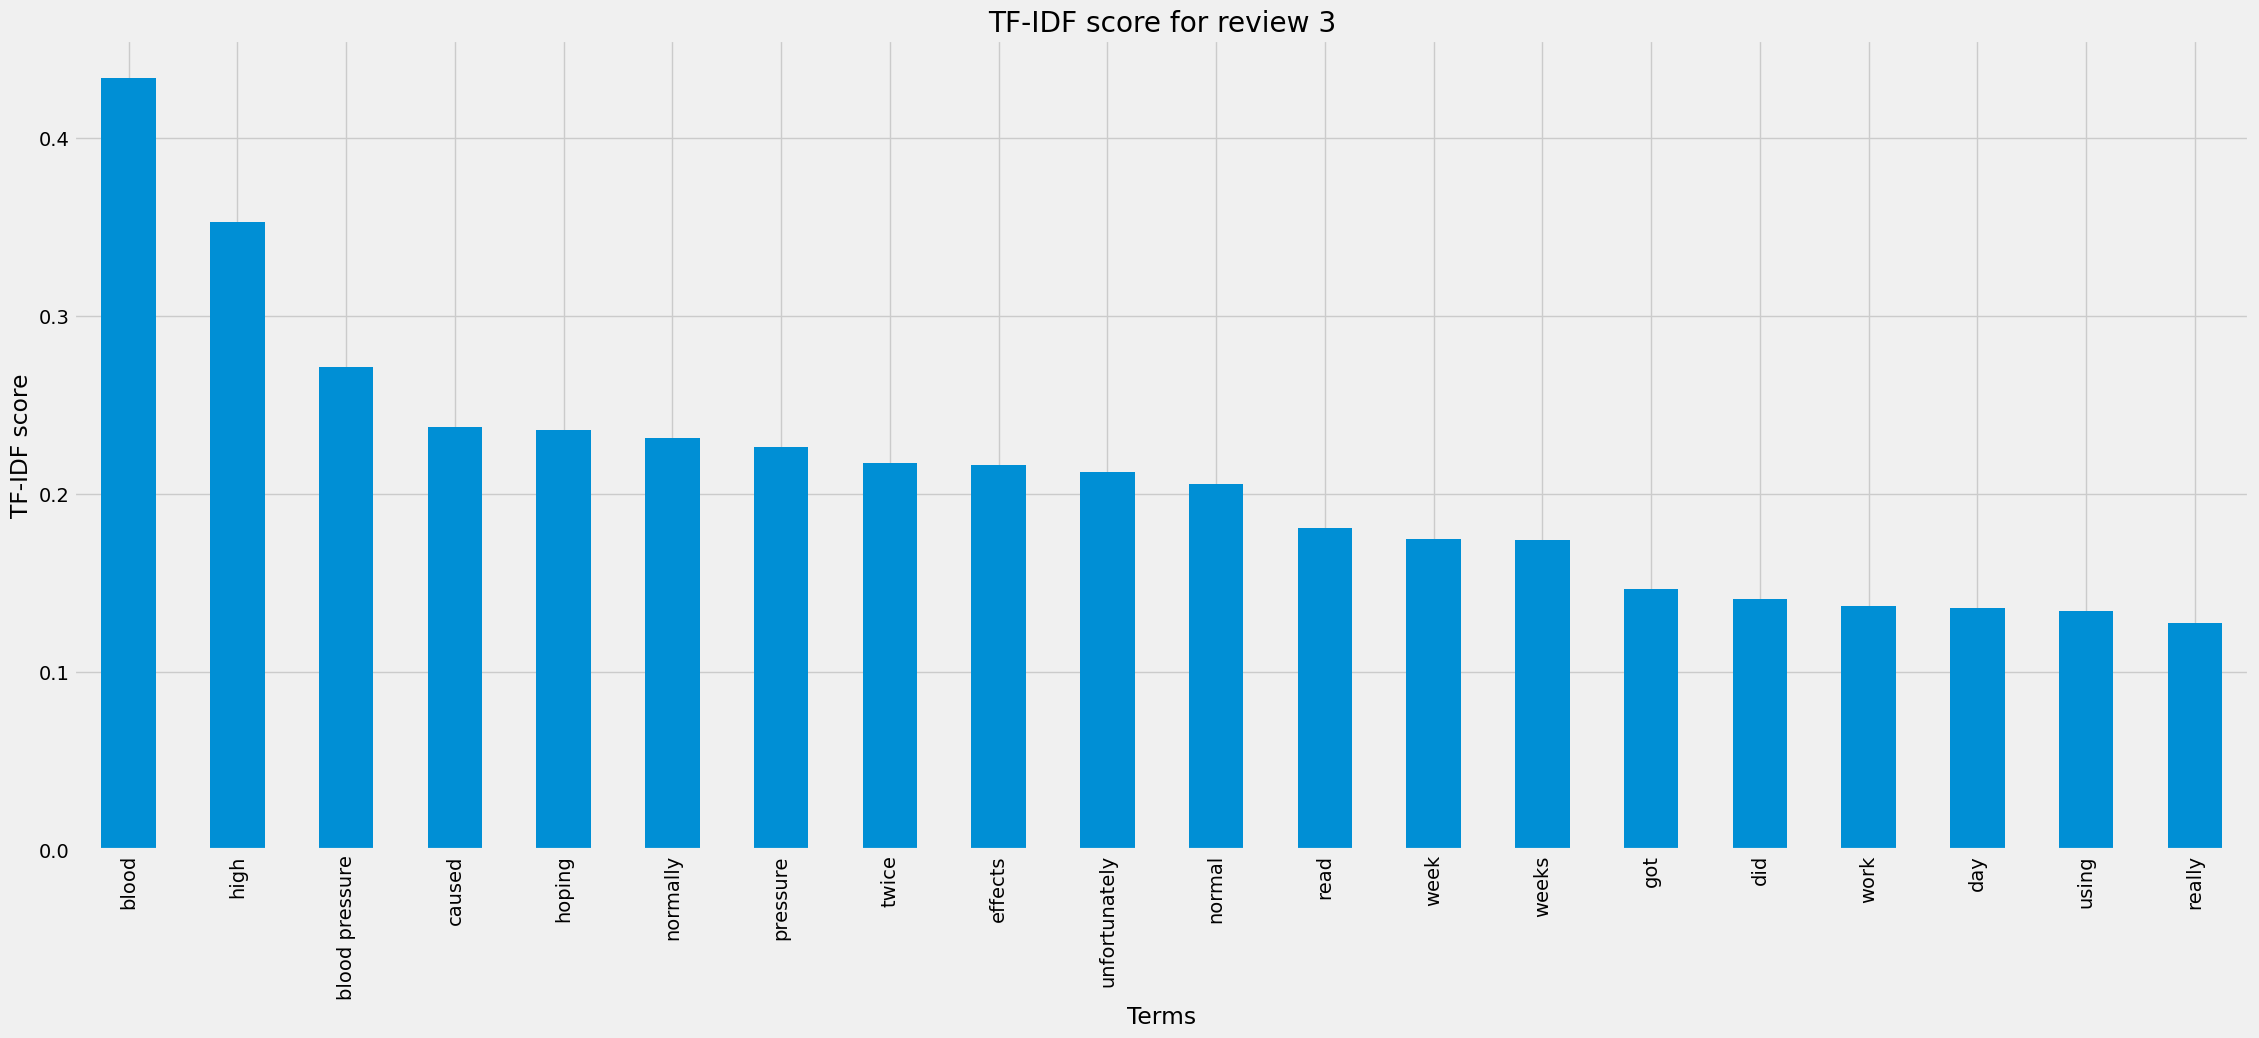

In [34]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sorted_doc_three_scores[:20].plot(kind = 'bar')
plt.title('TF-IDF score for review 3')
plt.ylabel('TF-IDF score')
plt.xlabel('Terms')

# Unsupervised model

In [35]:
model_nmf = NMF(n_components = 5, init = 'random', beta_loss = 'frobenius',  verbose = 1, random_state = 42).fit(df_tfidf)
# max_iter = 100,

violation: 1.0
violation: 0.6934153462325477
violation: 0.5121515645306972
violation: 0.42016548628094935
violation: 0.3531673695215581
violation: 0.3173505363838253
violation: 0.304870692566376
violation: 0.2821916605525351
violation: 0.22131011093613476
violation: 0.1577497727114116
violation: 0.11835364267996196
violation: 0.09816245080698677
violation: 0.08614800755369698
violation: 0.07825934577828964
violation: 0.07439632881320661
violation: 0.07283826964526623
violation: 0.07258361607244612
violation: 0.07247982243372333
violation: 0.07222675405874027
violation: 0.07137420445923554
violation: 0.06977949103663221
violation: 0.06772416277057246
violation: 0.06477656359622827
violation: 0.06029505440123463
violation: 0.05499251902202315
violation: 0.04926305267522612
violation: 0.04366133318995474
violation: 0.038662183402332705
violation: 0.034093512334996454
violation: 0.02993684603289013
violation: 0.026039822040185248
violation: 0.02242363480133579
violation: 0.0189131646631000

In [36]:
weights = model_nmf.transform(df_tfidf)
pd.DataFrame(weights).head()

violation: 1.0
violation: 0.27503520960051087
violation: 0.01846545516725426
violation: 0.0021747475964674317
violation: 0.00022013844441875517
violation: 2.09357022325617e-05
Converged at iteration 7


,0,1,2,3,4
0,0.000000,0.00000,0.000000,0.037555,0.014692
1,0.000000,0.00000,0.089517,0.036178,0.049504
2,0.000000,0.00000,0.134868,0.009340,0.056917
3,0.000000,0.00875,0.015489,0.109436,0.000000
4,0.002884,0.00000,0.026292,0.000000,0.126499


In [37]:
pred = np.argmax(weights, axis = 1)
pred

array([3, 2, 2, ..., 3, 2, 2])

In [46]:
pred = pred + 1

In [48]:
def label_compare(y, yp):
    '''Function that for all permutations of labels, retruns the best accuracy score and order'''
    global best_ordering
    unique_labels = np.unique(yp)
    best_accuracy = 0.0

    for order in permutations(unique_labels):
        label_map = {unique_labels[i]: order[i] for i in range(len(unique_labels))}
        reordered_yp = np.vectorize(label_map.get)(yp)

        current_score = accuracy_score(y, reordered_yp)
        if current_score > best_accuracy:
            best_accuracy = current_score
            best_ordering = order
        
    return best_accuracy

In [49]:
print(f'The best accuracy achieved with random hyperparameters for the NMF model is: {label_compare(y, pred)}')

The best accuracy achieved with random hyperparameters for the NMF model is: 0.30115167851016905


In [47]:
pred[:10]

array([4, 3, 3, 4, 5, 4, 4, 1, 4, 4])

In [50]:
y[:10]

[1, 5, 1, 2, 5, 5, 3, 5, 1, 5]

In [51]:
labels = np.unique(pred)
label_map = dict(zip(labels, best_ordering))
reorder_yp = np.array([label_map[lbl] for lbl in pred])

In [58]:
reorder_yp

array([1, 5, 5, ..., 1, 5, 5])

In [55]:
label_names = english_reviews_train['RATING'].unique().tolist()
label_names

[1, 5, 2, 3, 4]

In [56]:
l = pd.Index(label_names)
l

Index([1, 5, 2, 3, 4], dtype='int64')

In [57]:
cm = pd.crosstab(l[y], l[reorder_yp])

IndexError: index 5 is out of bounds for axis 0 with size 5

In [53]:
label_names = english_reviews_train['RATING'].unique().tolist()
l = pd.Index(label_names)
cm = pd.crosstab(l[y], l[reorder_yp])

plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, square=True, cmap='Reds', fmt='.0f', cbar=False)
plt.title('NMF random model confusion matrix', fontsize = 12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8)

IndexError: index 5 is out of bounds for axis 0 with size 5